<a href="https://colab.research.google.com/github/Kaushik2003/Clustering-ML-Model-Project/blob/main/Clustering_ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from kmodes.kprototypes import KPrototypes
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('dataset.csv')



ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

#Need to show Data Exploration
show graphs to present the data, help visualise data

Shape: (111, 7)

Columns: ['game_genre_top_1', 'game_genre_top_2', 'game_genre_top_3', 'music_genre_top_1', 'music_genre_top_2', 'music_genre_top_3', 'listening_hours']

Data types:
 game_genre_top_1     object
game_genre_top_2     object
game_genre_top_3     object
music_genre_top_1    object
music_genre_top_2    object
music_genre_top_3    object
listening_hours       int64
dtype: object

Missing values:
 game_genre_top_1     0
game_genre_top_2     0
game_genre_top_3     0
music_genre_top_1    0
music_genre_top_2    0
music_genre_top_3    0
listening_hours      0
dtype: int64
count    111.000000
mean       3.171171
std        2.568600
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       10.000000
Name: listening_hours, dtype: float64

Value counts for game_genre_top_1:
game_genre_top_1
FPS         27
Sports      22
Racing      15
Strategy    13
Puzzle      13
Casual      10
RPG          7
MOBA         4
Name: count, dtype: int64

Value counts for 

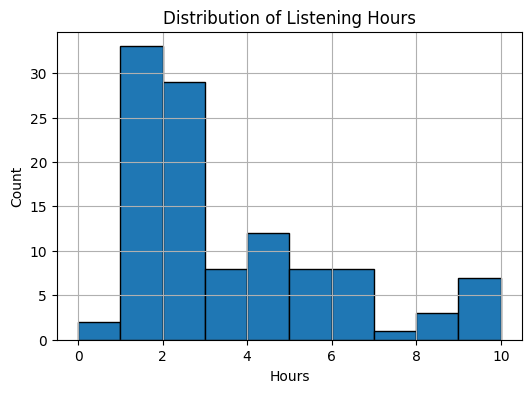

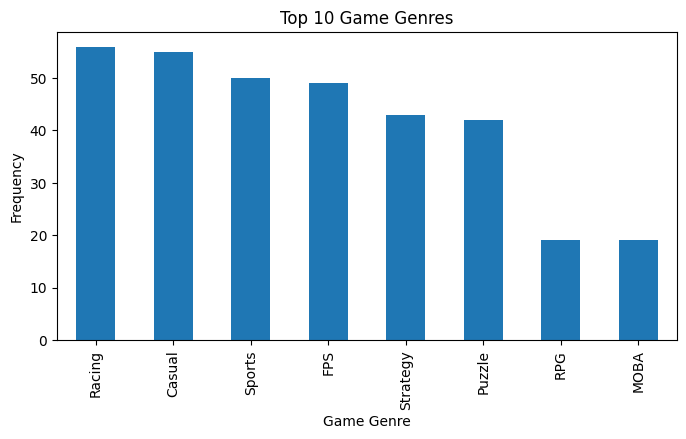

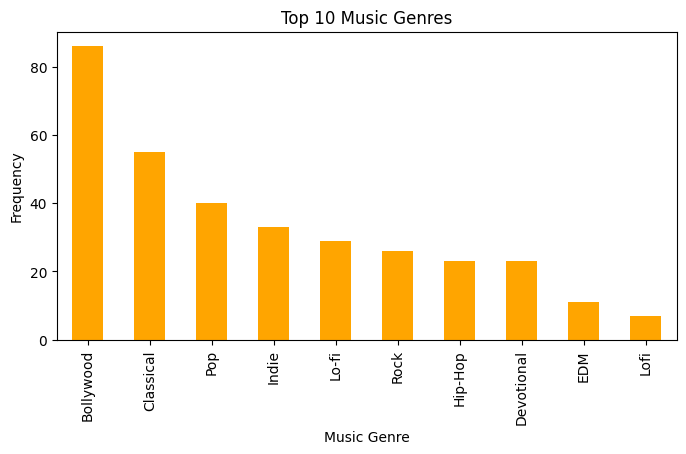

In [ ]:
# --- Doing some basic exploration ---
# Shape and column info
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Preview first rows
df.head()

# --- Summary of statistics and value counts ---
# Summary of listening_hours
print(df['listening_hours'].describe())

# Count of top values in categorical columns
for col in df.columns[:-1]:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts().head(10))

# --- Visualization of graphs for better understanding ---
import matplotlib.pyplot as plt

# Distribution of listening hours
plt.figure(figsize=(6,4))
df['listening_hours'].hist(bins=10, edgecolor='black')
plt.title("Distribution of Listening Hours")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.show()

# Top game genres (combine top 3 choices)
game_genres = pd.concat([df['game_genre_top_1'], df['game_genre_top_2'], df['game_genre_top_3']])
plt.figure(figsize=(8,4))
game_genres.value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Game Genres")
plt.xlabel("Game Genre")
plt.ylabel("Frequency")
plt.show()

# Top music genres (combine top 3 choices)
music_genres = pd.concat([df['music_genre_top_1'], df['music_genre_top_2'], df['music_genre_top_3']])
plt.figure(figsize=(8,4))
music_genres.value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Music Genres")
plt.xlabel("Music Genre")
plt.ylabel("Frequency")
plt.show()


##Data PreProcessing
show graphs if possible

Need to show from data exploration,
why we are using  rank based encoding(ordinal encoding ) for the categorical feat
and
standard scaling for the numerical.

Our dataset has ordered preferences:

*   game_genre_top_1 = most preferred
*   game_genre_top_2 = second preferred
*   game_genre_top_3 = third preferred

Same applies to music genres.

One-hot encoding treats all genres equally (no order), but here order matters.

Rank-based encoding preserves this preference ranking by assigning numeric scores like:


*  top_1 → 3
*  top_2 → 2
*  top_3 → 1

This makes the model understand that top choices are more important than lower ones.

In [ ]:
# --- 1. Data Preprocessing ---
print("--- Preprocessing Data for K-Prototypes ---")
# Define categorical and numerical features
categorical_features = ['game_genre_top_1', 'game_genre_top_2', 'game_genre_top_3', 'music_genre_top_1', 'music_genre_top_2', 'music_genre_top_3']
numerical_features = ['listening_hours']

# Create a copy for preprocessing
df_processed = df.copy()

# Rank/Ordinal Encoding for categorical features
ordinal_encoder = OrdinalEncoder()
df_processed[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])

# Standard Scaling for numerical features
scaler = StandardScaler()
df_processed[numerical_features] = scaler.fit_transform(df[numerical_features])

# Convert to numpy array for the algorithm
# explain why done. because we need to modify the rank based encoding in a way that we can use the K Protptype. we are basically making it compatible for K P
data_matrix = df_processed.values

# Get the indices of categorical columns
categorical_indices = [df_processed.columns.get_loc(col) for col in categorical_features]

--- Preprocessing Data for K-Prototypes ---


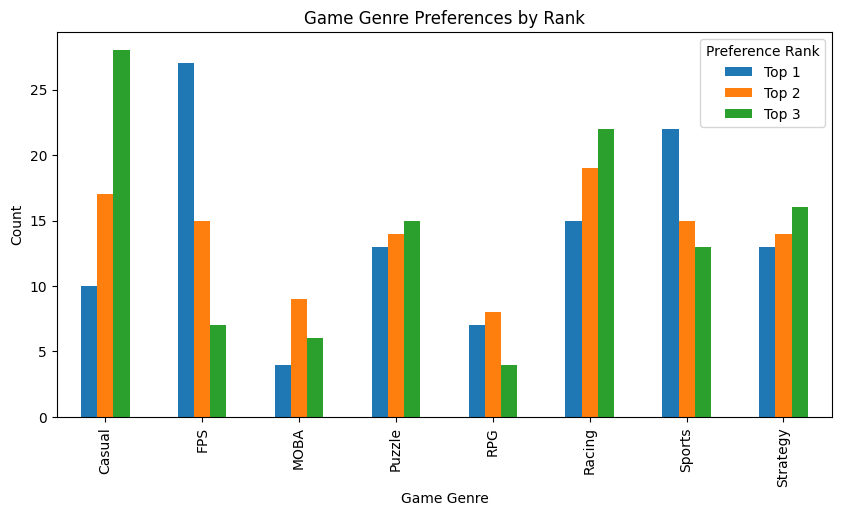

In [ ]:
# --- Showing categorial preferences and why rank based encoding is needed ---
# Count frequencies of game preferences
pref_counts = {
    "Top 1": df['game_genre_top_1'].value_counts(),
    "Top 2": df['game_genre_top_2'].value_counts(),
    "Top 3": df['game_genre_top_3'].value_counts(),
}

# Plot stacked bar
pref_df = pd.DataFrame(pref_counts).fillna(0)

pref_df.plot(kind="bar", figsize=(10,5))
plt.title("Game Genre Preferences by Rank")
plt.xlabel("Game Genre")
plt.ylabel("Count")
plt.legend(title="Preference Rank")
plt.show()


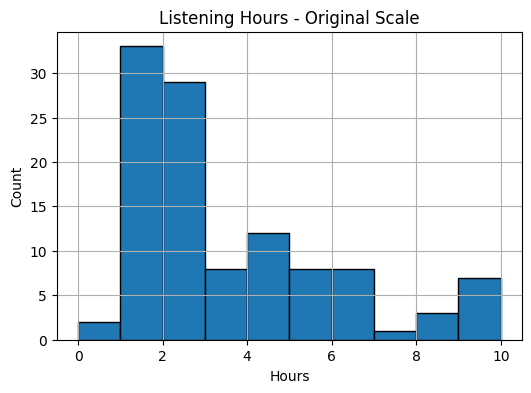

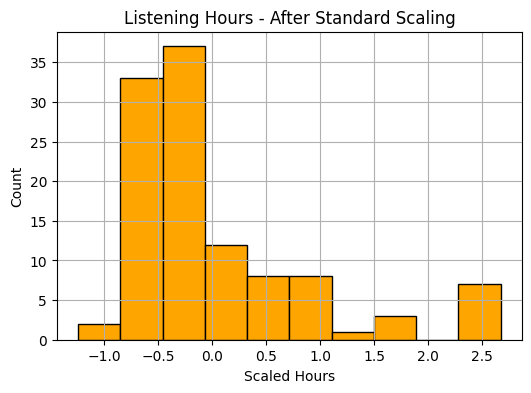

In [ ]:
# --- Showing numerical feature scale and why standard scaling is needed ---
# Histogram before scaling
plt.figure(figsize=(6,4))
df['listening_hours'].hist(bins=10, edgecolor="black")
plt.title("Listening Hours - Original Scale")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.show()

# Apply Standard Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled['listening_hours_scaled'] = scaler.fit_transform(df[['listening_hours']])

# Histogram after scaling
plt.figure(figsize=(6,4))
df_scaled['listening_hours_scaled'].hist(bins=10, edgecolor="black", color="orange")
plt.title("Listening Hours - After Standard Scaling")
plt.xlabel("Scaled Hours")
plt.ylabel("Count")
plt.show()


#Finding Optimal K with Elbow Method and Silhouette Method for K-Prototypes
show graphs,
explain from above related info
why we had to use K prototype because it supports categorical and numerical.
now after k prototype used,
we find optimal clusters with respect to their individual silhoutte scores and cost.
fromt those graphs, we apply the elbow method
check where there cluster is 3 /4
if while research you find 3 is good then continue explaining
but if 4 then contact kaushik,


--- Finding Optimal K using Elbow and Silhouette Method for K-Prototypes ---
Running K-Prototypes for K=2...
Running K-Prototypes for K=3...
Running K-Prototypes for K=4...
Running K-Prototypes for K=5...
Running K-Prototypes for K=6...
Running K-Prototypes for K=7...

Elbow and Silhouette method plots saved as kprototypes_elbow_silhouette_methods.png

Selected optimal K = 3 based on the plots.


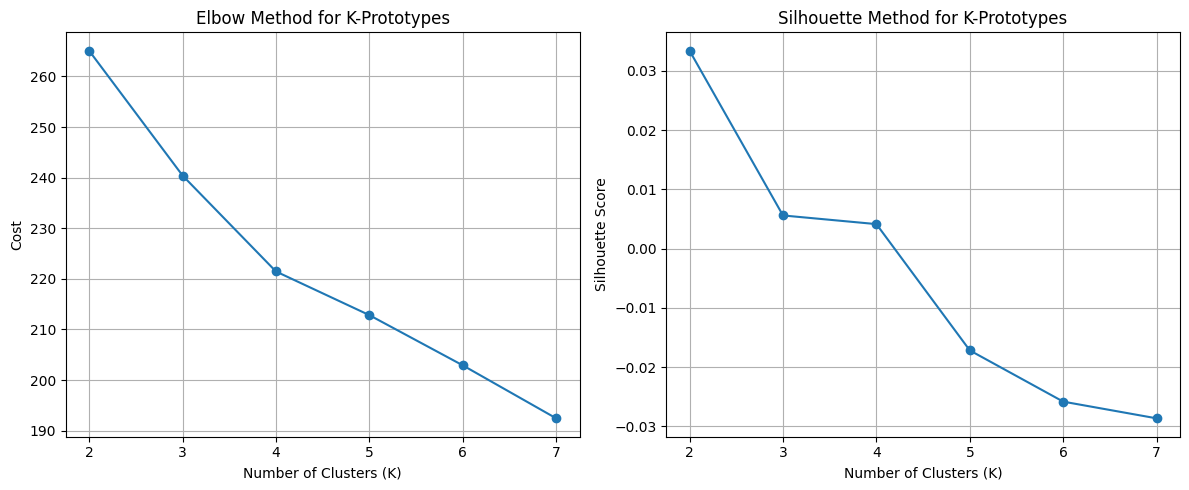

In [ ]:

# --- 2. Finding Optimal K with Elbow Method and Silhouette Method for K-Prototypes ---
print("\n--- Finding Optimal K using Elbow and Silhouette Method for K-Prototypes ---")
costs = []
silhouette_scores = []
cluster_range = range(2, 8) # Reduced range for faster execution with dummy data

for k in cluster_range:
    print(f"Running K-Prototypes for K={k}...")
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=10, random_state=42, verbose=0)
    clusters = kproto.fit_predict(data_matrix, categorical=categorical_indices)
    costs.append(kproto.cost_)
    silhouette_scores.append(silhouette_score(data_matrix, clusters))

# Plot the Elbow Method graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, costs, marker='o')
plt.title('Elbow Method for K-Prototypes')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.xticks(cluster_range)
plt.grid(True)

# Plot the Silhouette Method graph
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Method for K-Prototypes')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)

plt.tight_layout()
plt.savefig('kprototypes_elbow_silhouette_methods.png')
print("\nElbow and Silhouette method plots saved as kprototypes_elbow_silhouette_methods.png")

# Based on the plots, let's select the optimal K.
# For the elbow method, we look for the "elbow" point.
# For the silhouette method, we look for the highest score.
# Let's say, after visual inspection, K=3 is a good choice.


# based on elbow method
best_k = 3


print(f"\nSelected optimal K = {best_k} based on the plots.")




Building the Final K-Prototypes Model


so show the Cluster model with proper visualization, some steps are mentioned in step 5.
try pca or tsne.



--- Building Final K-Prototypes Model with K=3 ---

--- Analysis of K-Prototypes Clusters ---

--- Persona for Cluster 0 ---
Number of students: 66
Top Game Genres:
game_genre_top_1
FPS         21
Sports      14
Strategy     9
Name: count, dtype: int64

Top Music Genres:
music_genre_top_1
Bollywood    42
Lofi          6
Classical     6
Name: count, dtype: int64

Average Listening Hours: 1.55

--- Persona for Cluster 1 ---
Number of students: 33
Top Game Genres:
game_genre_top_1
Sports    8
Puzzle    7
Racing    6
Name: count, dtype: int64

Top Music Genres:
music_genre_top_1
Bollywood    16
Pop           4
Classical     4
Name: count, dtype: int64

Average Listening Hours: 4.33

--- Persona for Cluster 2 ---
Number of students: 12
Top Game Genres:
game_genre_top_1
Racing    5
FPS       4
RPG       1
Name: count, dtype: int64

Top Music Genres:
music_genre_top_1
Bollywood    3
EDM          2
Hip-Hop      2
Name: count, dtype: int64

Average Listening Hours: 8.92

Final cluster visualiz

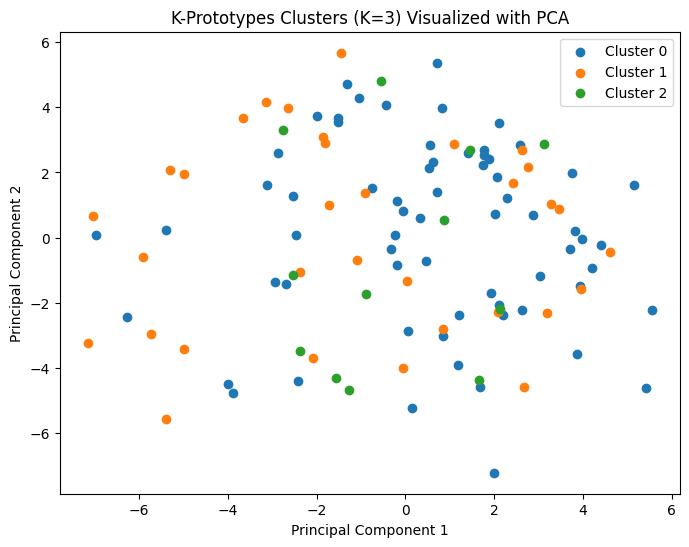

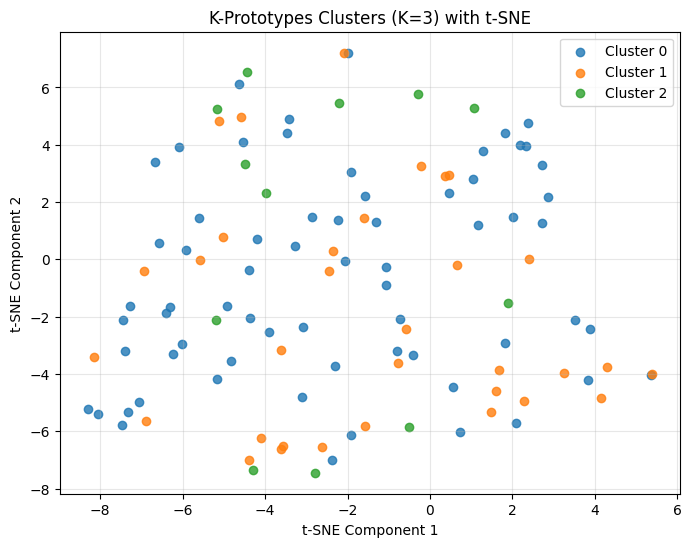

In [ ]:
# --- 3. Building the Final K-Prototypes Model ---
print(f"\n--- Building Final K-Prototypes Model with K={best_k} ---")
final_kproto = KPrototypes(n_clusters=best_k, init='Cao', n_init=10, random_state=42)
clusters = final_kproto.fit_predict(data_matrix, categorical=categorical_indices)

# --- 4. Adding Cluster Labels and Analyzing Clusters ---
df['cluster'] = clusters
print("\n--- Analysis of K-Prototypes Clusters ---")

for i in range(best_k):
    cluster_df = df[df['cluster'] == i]
    print(f"\n--- Persona for Cluster {i} ---")
    print(f"Number of students: {len(cluster_df)}")

    print("Top Game Genres:")
    print(cluster_df['game_genre_top_1'].value_counts().head(3))
    print("\nTop Music Genres:")
    print(cluster_df['music_genre_top_1'].value_counts().head(3))
    print(f"\nAverage Listening Hours: {cluster_df['listening_hours'].mean():.2f}")


# --- 5. Visualization of the Final Clusters ---
# Using PCA for visualization on the scaled/encoded data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_matrix)

pca_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])
pca_df['cluster'] = df['cluster']

plt.figure(figsize=(8, 6))
for i in range(best_k):
    plt.scatter(pca_df.loc[pca_df['cluster'] == i, 'principal_component_1'],
                pca_df.loc[pca_df['cluster'] == i, 'principal_component_2'],
                label=f'Cluster {i}')
plt.title(f'K-Prototypes Clusters (K={best_k}) Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.savefig(f'kprototypes_clusters_k{best_k}.png')
print(f"\nFinal cluster visualization saved as kprototypes_clusters_k{best_k}.png")

# Using t-sne for visualization
print("\nComputing t-SNE... (this may take some time)")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df)-1))
tsne_components = tsne.fit_transform(data_matrix)

tsne_df = pd.DataFrame(data=tsne_components, columns=['t-SNE1', 't-SNE2'])
tsne_df['cluster'] = df['cluster']

plt.figure(figsize=(8, 6))
for i in range(best_k):
    plt.scatter(tsne_df.loc[tsne_df['cluster'] == i, 't-SNE1'],
                tsne_df.loc[tsne_df['cluster'] == i, 't-SNE2'],
                label=f'Cluster {i}', alpha=0.8)
plt.title(f'K-Prototypes Clusters (K={best_k}) with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

based on previous graphs,
now we show recommendations based on cluster information, some steps are done in step 4

show individual cluster information,
based on that information and graphs,

then the final steps,
we show
recommended gamer-music overlaps to create maximum event participation






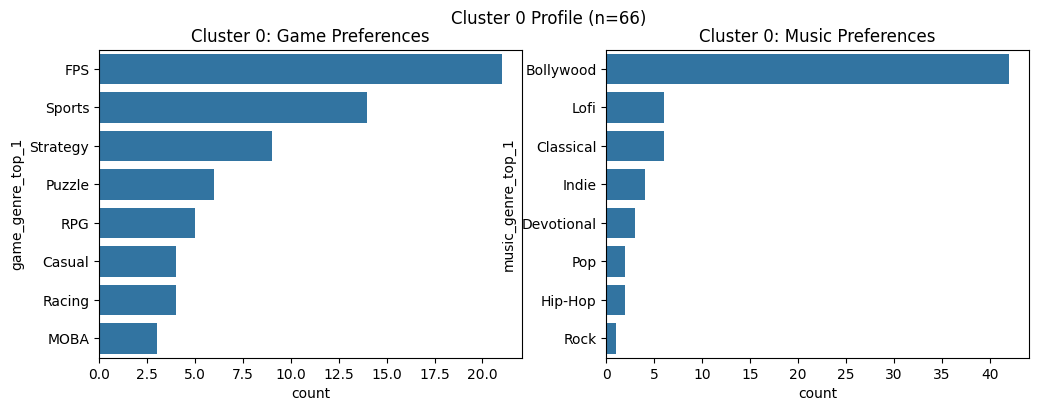

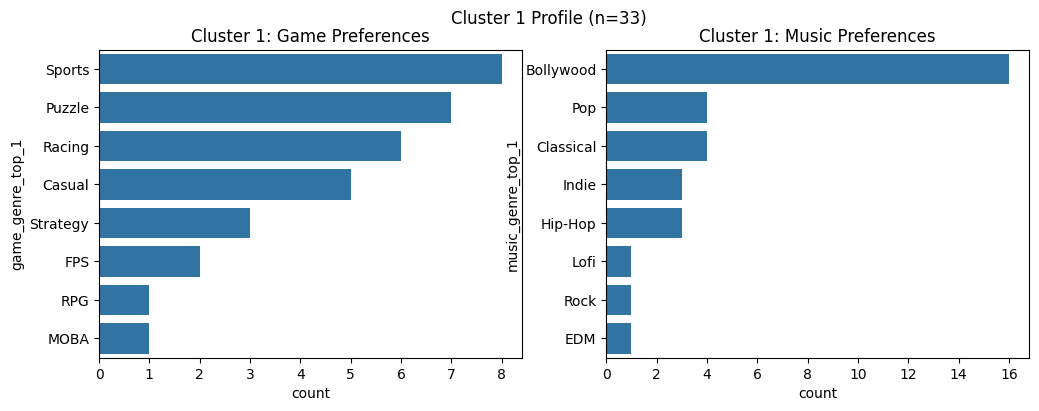

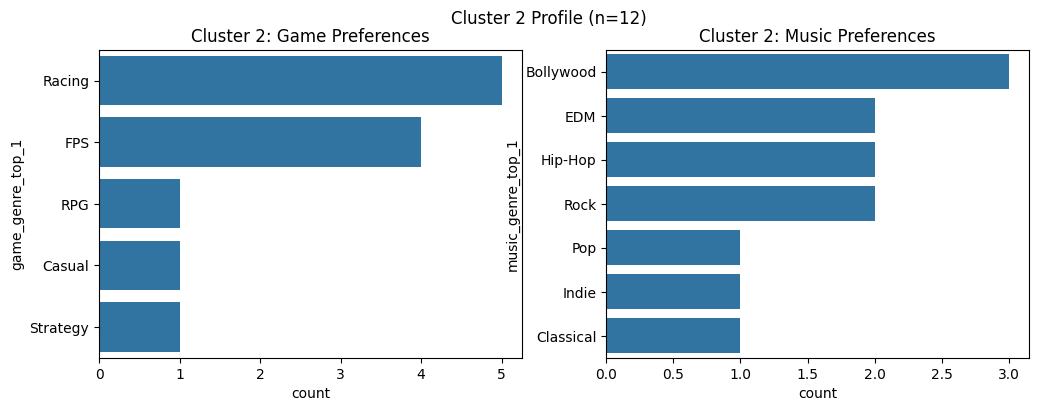


--- Final Event Recommendations ---

🎉 Event 1 (Cluster 0 - 66 students)
- Recommended Games: FPS, Sports
- Recommended Music: Bollywood, Lofi
- Avg Listening Hours: 1.55

🎉 Event 2 (Cluster 1 - 33 students)
- Recommended Games: Sports, Puzzle
- Recommended Music: Bollywood, Pop
- Avg Listening Hours: 4.33

🎉 Event 3 (Cluster 2 - 12 students)
- Recommended Games: Racing, FPS
- Recommended Music: Bollywood, EDM
- Avg Listening Hours: 8.92


In [ ]:
# --- Showing the final recommendations based on cluster info ---
# Extracting cluster insights
cluster_profiles = {}

for i in range(best_k):
    cluster_df = df[df['cluster'] == i]

    top_games = cluster_df['game_genre_top_1'].value_counts().head(2).index.tolist()
    top_music = cluster_df['music_genre_top_1'].value_counts().head(2).index.tolist()
    avg_hours = cluster_df['listening_hours'].mean()

    cluster_profiles[i] = {
        "size": len(cluster_df),
        "top_games": top_games,
        "top_music": top_music,
        "avg_hours": avg_hours
    }

cluster_profiles

# Visualizing cluster profiles
import seaborn as sns
for i in range(best_k):
    cluster_df = df[df['cluster'] == i]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Top Games
    sns.countplot(y=cluster_df['game_genre_top_1'], order=cluster_df['game_genre_top_1'].value_counts().index, ax=axes[0])
    axes[0].set_title(f"Cluster {i}: Game Preferences")

    # Top Music
    sns.countplot(y=cluster_df['music_genre_top_1'], order=cluster_df['music_genre_top_1'].value_counts().index, ax=axes[1])
    axes[1].set_title(f"Cluster {i}: Music Preferences")

    plt.suptitle(f"Cluster {i} Profile (n={len(cluster_df)})")
    plt.show()

# Final recommended events
print("\n--- Final Event Recommendations ---")

for i in range(best_k):
    profile = cluster_profiles[i]

    event_games = ", ".join(profile["top_games"])
    event_music = ", ".join(profile["top_music"])

    print(f"\n🎉 Event {i+1} (Cluster {i} - {profile['size']} students)")
    print(f"- Recommended Games: {event_games}")
    print(f"- Recommended Music: {event_music}")
    print(f"- Avg Listening Hours: {profile['avg_hours']:.2f}")

